# Introduction

## Foreword

This is the final notebook that tests our best model on the testing data set.

## Problem Statement

The rapid evolution of generative artificial intelligence (GPAI, LLMs) social media has rapidly increased the public’s access to powerful, deceptive tools. One such concern is the increasing prevalence of deepfake images, which pose a significant threat to public trust and undermines the epistemic integrity of visual media. (Source).

These manipulated images can be utilized to spread false information, manipulate public opinion, and polarize communities, which can have serious consequences for both social and political discourse. In this project, we aim to develop a machine learning model that can detect differences between deepfakes and real images to combat the spread of manipulated visual media and protect the integrity of social discourse.

## Imports, Global Variables, and Helper Functions

In [190]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Resizing
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

import sys
sys.path.append("../../")
 
from Helper import config

## Data Loading

In [10]:
test_directory = "../../../Data/Test/"

test_ds = image_dataset_from_directory(
    directory=test_directory,
    image_size=(256, 256),
    batch_size=64,
    seed=42,
    label_mode="binary",
    labels="inferred"
)

Found 10910 files belonging to 2 classes.


# Modeling

## Loading Model

In [12]:
model_path = "../../PretrainedModel/dffnetv2B0.json"
weights_path = "../../PretrainedModel/dffnetv2B0_weights.h5"

model = config.load_trained_model(model_path, weights_path)

## Testing

In [191]:
test_scores = model.evaluate(test_ds)

171/171 [==============================] - 63s 365ms/step - loss: 0.5126 - binary_accuracy: 0.8577 - auc: 0.9387 - precision: 0.9188 - recall: 0.7828 - true_negatives: 5117.0000 - true_positives: 4241.0000 - false_positives: 375.0000 - false_negatives: 1177.0000


In [194]:
model.metrics_names

['loss',
 'binary_accuracy',
 'auc',
 'precision',
 'recall',
 'true_negatives',
 'true_positives',
 'false_positives',
 'false_negatives']

## Read in Model Evaluation CSV

In [41]:
df = pd.read_csv("../../Results/model_eval.csv")
df.set_index("Unnamed: 0", drop=True, inplace=True)
df.dropna(inplace=True)
df.head()

,train_loss,train_acc,train_precision,train_recall,train_auc,train_fn,train_fp,train_tn,train_tp,val_loss,val_acc,val_precision,val_recall,val_auc,val_fn,val_fp,val_tn,val_tp
Unnamed: 0,,,,,,,,,,,,,,,,,,
model_1,0.046418,0.983007,0.981008,0.985086,0.998207,1044.0,1335.0,68666.0,68957.0,0.728149,0.859973,0.848666,0.877445,0.918686,2425.0,3096.0,16545.0,17362.0
efficientnetv2-b0_retrain,0.003119,0.977746,0.994270,0.963431,0.993228,86257.0,89180.0,3385.0,608.0,0.119601,0.965126,0.991854,0.949819,0.982413,18614.0,19439.0,1027.0,348.0
cnn_reid,0.052528,0.978279,0.998641,0.963815,0.993872,67389.0,69572.0,2612.0,429.0,0.367717,0.902252,0.965261,0.853517,0.972052,16340.0,19234.0,3301.0,553.0
cnn_baseline,0.202000,0.917600,0.910000,0.927000,0.974700,5112.0,6418.0,63583.0,64889.0,0.421600,0.821600,0.772300,0.913900,0.916900,1704.0,5331.0,14310.0,18083.0


In [192]:
df_v2 = pd.read_csv("../../Results/v2b0_history.csv")
df_v2.drop(columns="Unnamed: 0", inplace=True)
df_v2.tail()


,loss,acc,val_loss,val_acc
5,0.017042,0.994386,0.116809,0.961398
6,0.011981,0.996143,0.109179,0.964873
7,0.008667,0.997243,0.114847,0.965532
8,0.006824,0.997772,0.104951,0.968981
9,0.005208,0.998536,0.119601,0.965126


## Graphing

#### Set Plot Style

In [154]:
import seaborn as sns
sns.set_style('whitegrid')

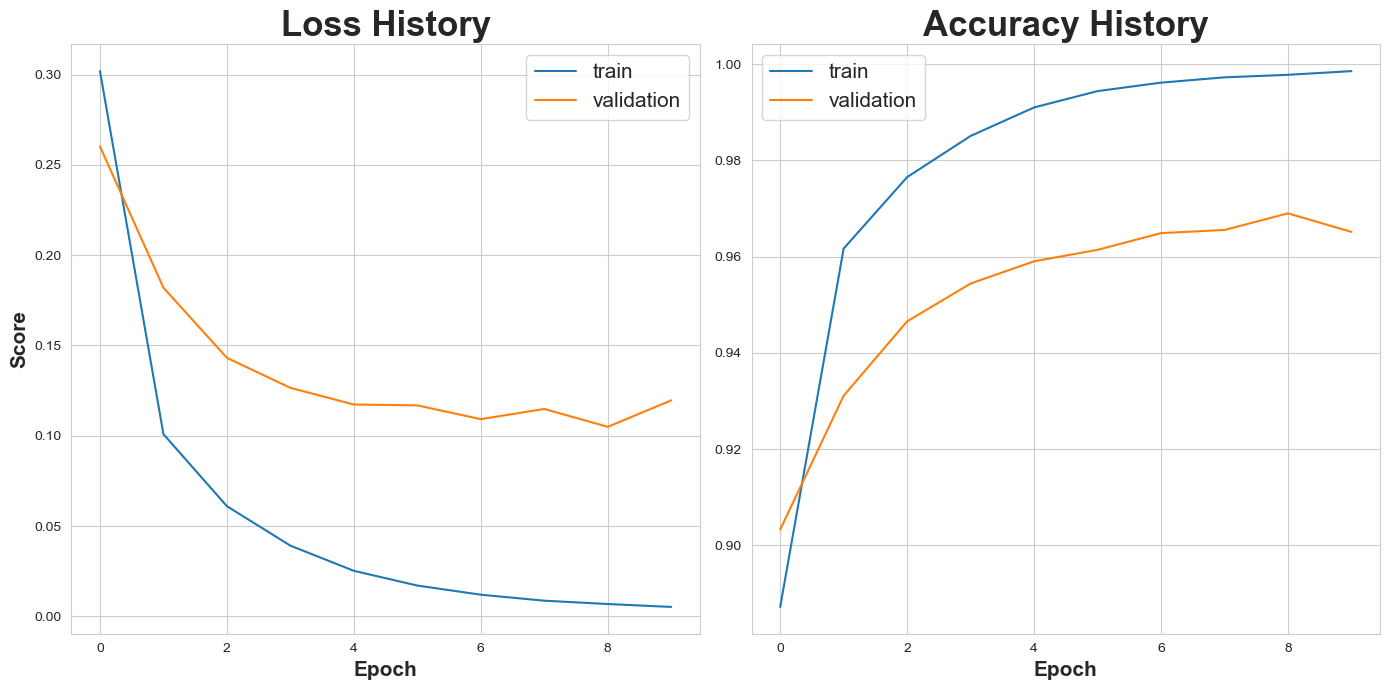

In [153]:
# Configure figure and plots
fig, ax = plt.subplots(1, 2, figsize=config.subplot_fig_size)

# Create data lists for graphing to loop over
titles = ["Loss History", "Accuracy History"]
data = ["loss", "acc"]
val_data = ["val_loss", "val_acc"]

ax[0].set_ylabel("Score", **config.axis_title_font)
# Graphs the data
for i in range(len(ax)):
    ax[i].set_title(titles[i], **config.title_font)
    ax[i].set_xlabel("Epoch", **config.axis_title_font)
    ax[i].plot(df_v2[data[i]], label="train")
    ax[i].plot(df_v2[val_data[i]], label="validation")
    ax[i].legend(loc='best', **config.label_font)
plt.tight_layout()
plt.savefig("../../../Images/v2b0_history.png")
plt.show()

In [45]:
# Get dataset as array
dataset_as_array = list(test_ds.as_numpy_iterator())

# Separate Image and Label Arrays
label_batches = [dataset_as_array[i][1] for i in range(len(dataset_as_array))]
image_batches = [dataset_as_array[i][0] for i in range(len(dataset_as_array))]

# Unpack Image and Label Batches into Single Array
unpacked_label_batches = np.vstack(label_batches)
unpacked_image_batches = np.vstack(image_batches)

# Get predictions in batches
predicted_probs = []

for i in range(0, 11000, 1000):
    if i + 1000 < 10910:
        preds = model.predict(unpacked_image_batches[i:i+1000])
        predicted_probs.append(preds)
    else:
        preds = model.predict(unpacked_image_batches[i:])
        predicted_probs.append(preds)

# Get true and predicted values as arrays        
y_true = unpacked_label_batches
y_pred_probs = np.vstack(predicted_probs)
y_preds = np.round(y_pred_probs)

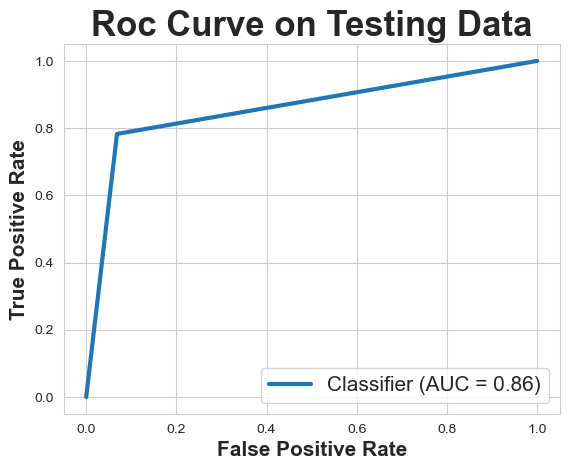

In [189]:
RocCurveDisplay.from_predictions(y_true, y_preds, linewidth=3)
plt.title("Roc Curve on Testing Data", **config.title_font)
plt.ylabel("True Positive Rate", **config.axis_title_font)
plt.xlabel("False Positive Rate", **config.axis_title_font)
plt.legend(**config.label_font, loc='lower right')
plt.savefig("../../../Images/v2b0_roc.png");

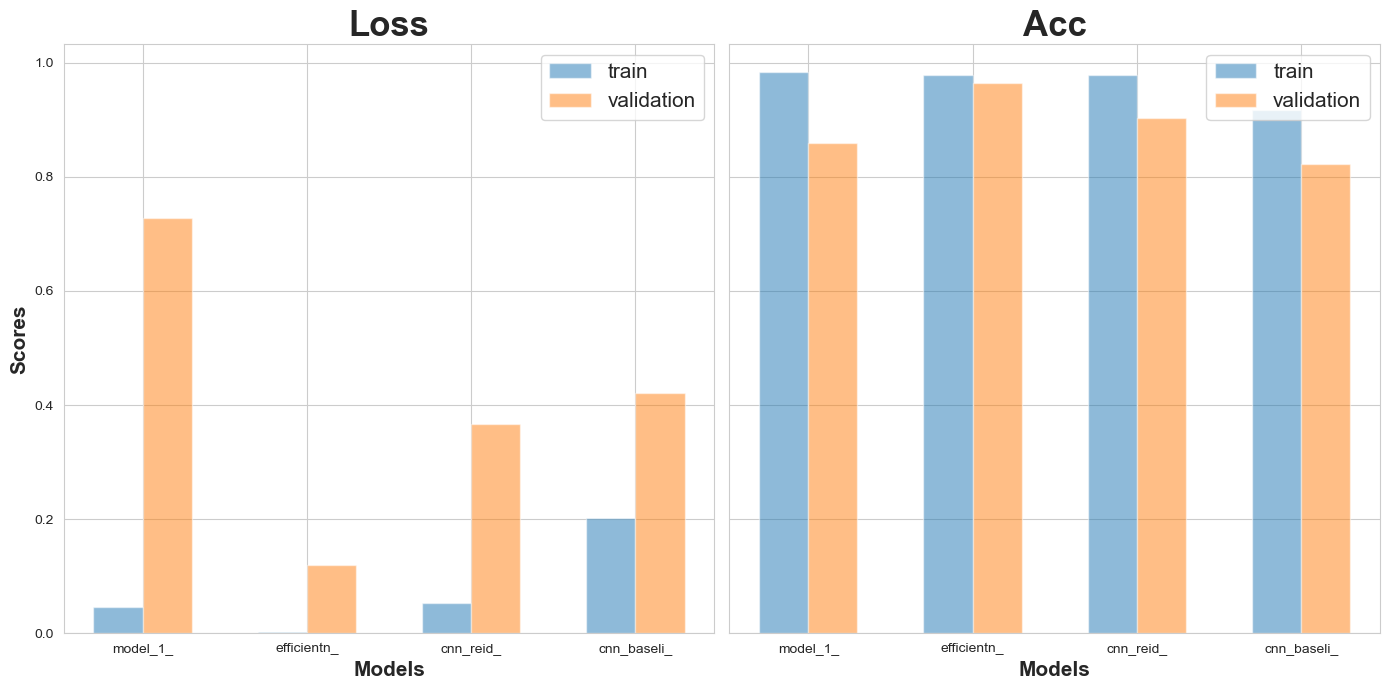

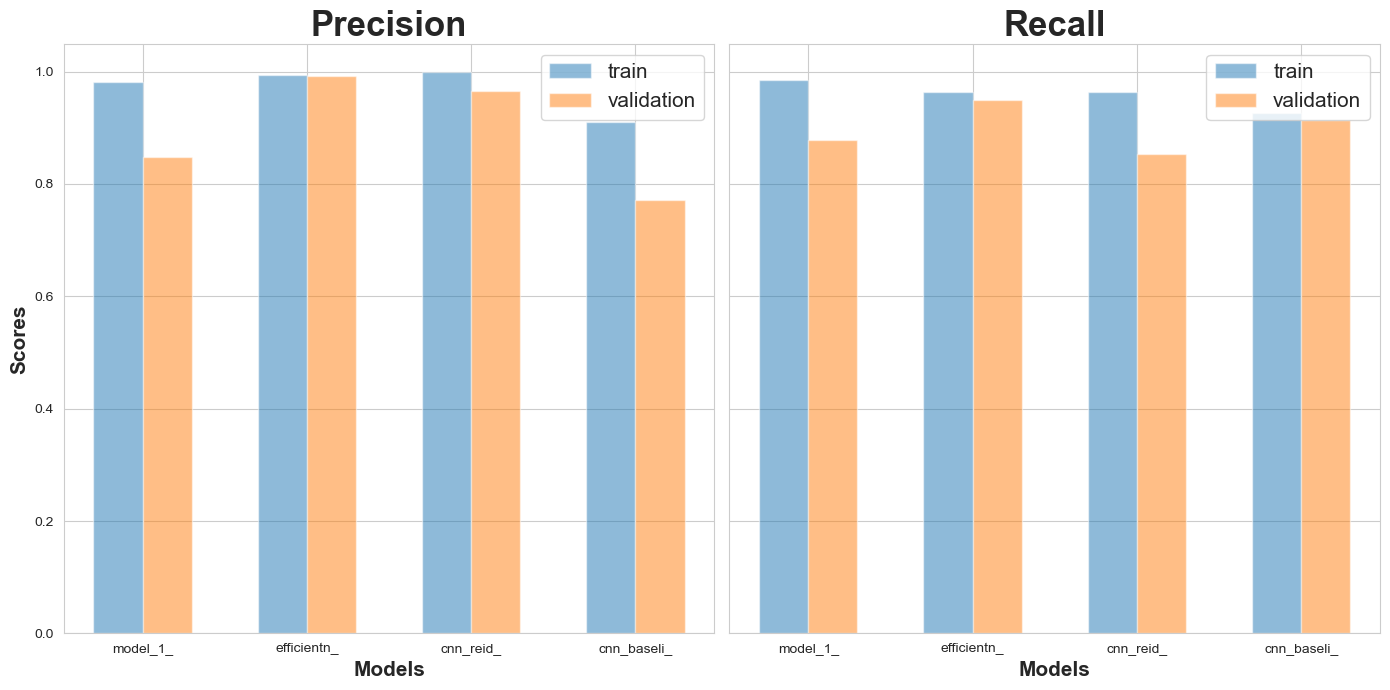

In [172]:
def plot_bar(df, list_of_columns):

    # Configure figure and plots
    total_graphs = len(list_of_columns)
    fig, ax = plt.subplots(1, total_graphs, figsize=config.subplot_fig_size, sharey=True)

    # Create data lists for graphing to loop over
    x_tick_labels = [f"{index[:10]}_" for index in df.index.to_list()]
    width = 0.3

    # Graphs the data
    ax[0].set_ylabel("Scores", **config.axis_title_font)
    for i in range(len(ax)):
        x_tick_indexes = np.arange(len(x_tick_labels))
        ax[i].set_title(f"{list_of_columns[i].title()}", **config.title_font)
        ax[i].set_xlabel("Models", **config.axis_title_font)
        ax[i].bar(x_tick_indexes, df[f"train_{list_of_columns[i]}"], width, label="train", alpha=0.5)
        ax[i].bar(x_tick_indexes + width, df[f"val_{list_of_columns[i]}"], width, label="validation", alpha=0.5)
        ax[i].set_xticks(x_tick_indexes + width / 2, x_tick_labels)
        ax[i].legend(loc='best', **config.label_font)
    plt.tight_layout()
    plt.savefig(f"../../../Images/{list_of_columns[0]}_{list_of_columns[1]}.png")
    plt.show()
    return

plot_bar(df, ["loss", "acc"])
plot_bar(df, ["precision", "recall"])